# Make line plots to show and compare ice surface elevation for different years

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utm as utm
from pyresample import kd_tree, geometry, bilinear
import glob as glob

# Swath 002 10m

In [68]:
grd_dir = '/Users/ifenty/Documents/Work/My Projects/2019_omg_intern_tmp/002/002_greenl_mine_t003_r015e/002_greenl_29101_greenl_29100_netCDF/'
#grd_dir = '/Users/ifenty/Documents/Work/My Projects/2019_omg_intern_tmp/002/002_greenl_mine_t025_r200e/002_greenl_29101_greenl_29100_netCDF/'
g = np.sort(glob.glob(grd_dir + '/*nc'))
g

array(['/Users/ifenty/Documents/Work/My Projects/2019_omg_intern_tmp/002/002_greenl_mine_t003_r015e/002_greenl_29101_greenl_29100_netCDF/15m_greenl_29100_17031_002_170314_ALTTBB_HH_04testing3.nc',
       '/Users/ifenty/Documents/Work/My Projects/2019_omg_intern_tmp/002/002_greenl_mine_t003_r015e/002_greenl_29101_greenl_29100_netCDF/15m_greenl_29100_18010_015_180308_ALTTBB_HH_01testing3.nc',
       '/Users/ifenty/Documents/Work/My Projects/2019_omg_intern_tmp/002/002_greenl_mine_t003_r015e/002_greenl_29101_greenl_29100_netCDF/15m_greenl_29101_16027_004_160321_ALTTBB_HH_03testing3.nc'],
      dtype='<U186')

# pay attention to which item of g has which year

In [69]:
s_002_2016 = xr.open_dataset(g[2])
s_002_2017 = xr.open_dataset(g[0])
s_002_2018 = xr.open_dataset(g[1])

In [70]:
s_002_2018

<xarray.Dataset>
Dimensions:    (x: 5111, y: 3089)
Coordinates:
  * x          (x) float64 5.65e+05 5.65e+05 5.65e+05 ... 6.416e+05 6.417e+05
    lon        (y, x) float64 ...
    lat        (y, x) float64 ...
  * y          (y) float64 6.797e+06 6.797e+06 6.797e+06 ... 6.843e+06 6.843e+06
Data variables:
    elevation  (y, x) float64 ...
Attributes:
    xmin:                             565007
    ymax:                             6843327
    spacing:                          15
    no_data:                          nan
    proj4text:                        +proj=utm +zone=23.0 +ellps=WGS84 +datu...
    proj4string:                      +proj=utm +zone=23.0 +ellps=WGS84 +datu...
    Projection:                       UTM 23N 002_greenl_29101_greenl_29100
    proj4:                            +init=epsg:32623
    Insitution:                       JPL
    Mission:                          Oceans Melting Greenland
    Mission website:                  https://omg.jpl.nasa.gov/portal/
    

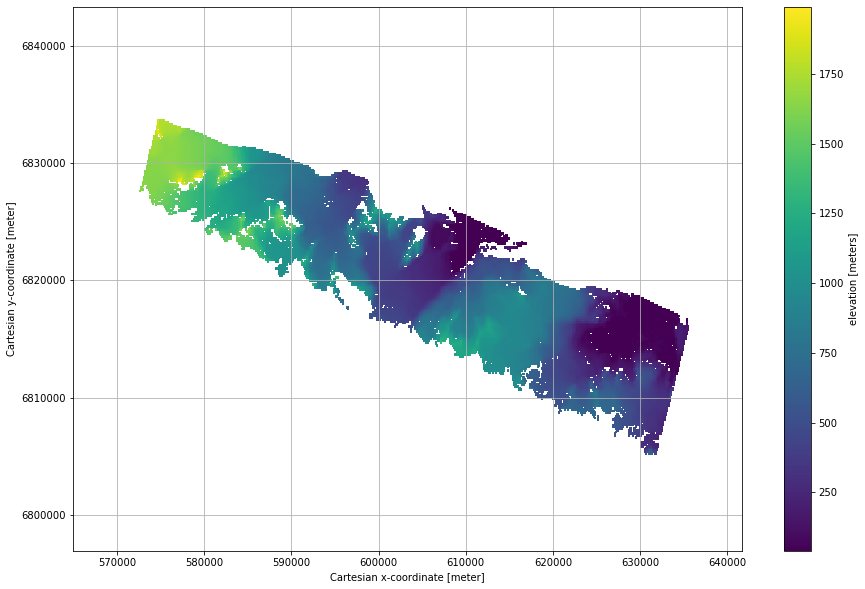

In [131]:
plt.figure(figsize=(15,10));s_002_2018.elevation[::10,::10].plot()
plt.grid()

## Difference 2018 and 2017

In [71]:
delta_z_18_minus_17 = s_002_2018 - s_002_2017

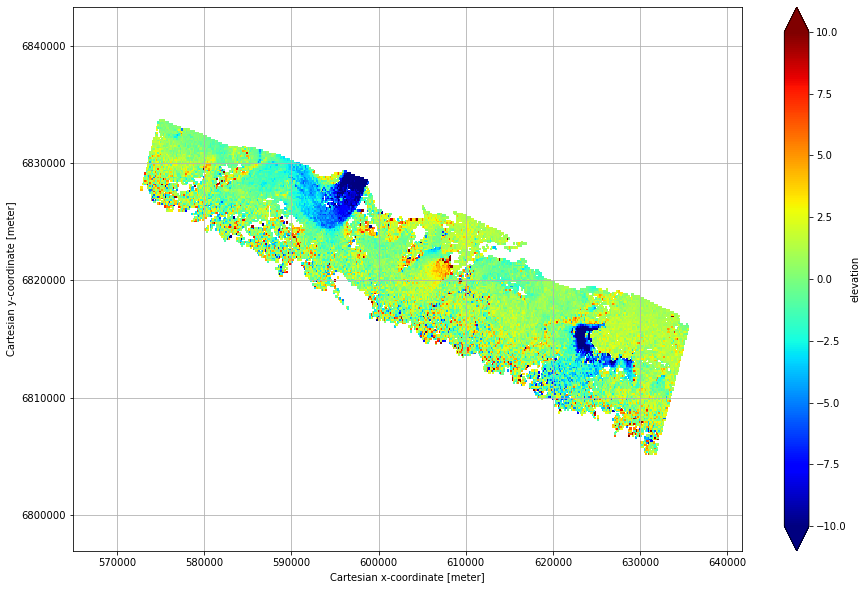

In [72]:
plt.figure(figsize=(15,10));delta_z_18_minus_17.elevation[::10,::10].plot(vmin=-10, vmax=10, cmap='jet')
plt.grid()

In [73]:
delta_z_18_minus_17

<xarray.Dataset>
Dimensions:    (x: 5111, y: 3089)
Coordinates:
  * x          (x) float64 5.65e+05 5.65e+05 5.65e+05 ... 6.416e+05 6.417e+05
    lon        (y, x) float64 -43.77 -43.77 -43.77 ... -42.36 -42.36 -42.36
    lat        (y, x) float64 61.3 61.3 61.3 61.3 61.3 ... 61.7 61.7 61.7 61.7
  * y          (y) float64 6.797e+06 6.797e+06 6.797e+06 ... 6.843e+06 6.843e+06
Data variables:
    elevation  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

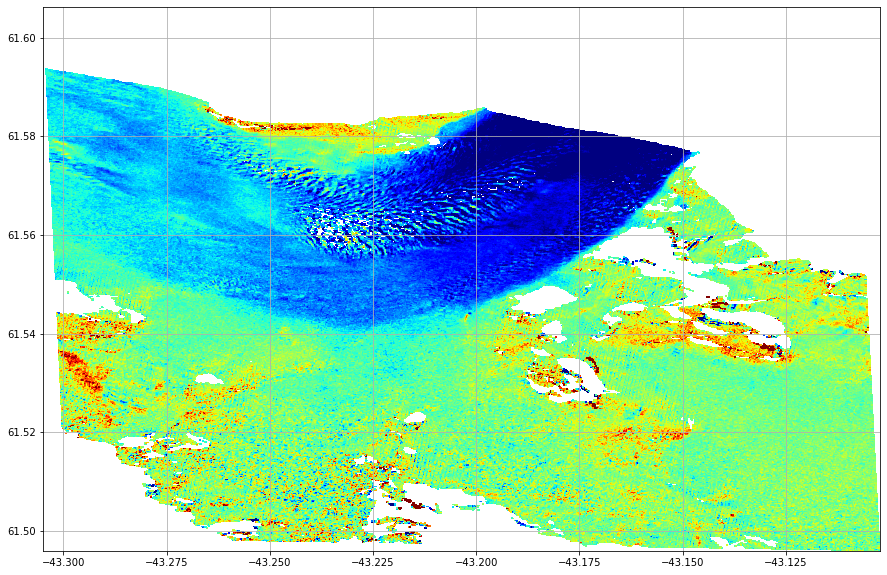

In [133]:
plt.figure(figsize=(15,10));
start_r = 1500;end_r = 2300
start_c = 1700;end_c = 2400;

lon = delta_z_18_minus_17.lon[start_r:end_r, start_c:end_c]
lat = delta_z_18_minus_17.lat[start_r:end_r, start_c:end_c]
ele = delta_z_18_minus_17.elevation[start_r:end_r, start_c:end_c]
plt.pcolormesh(lon, lat, ele, vmin=-10, vmax=10, cmap='jet')
plt.grid()

# Pick two points on the UTM grid, A and B

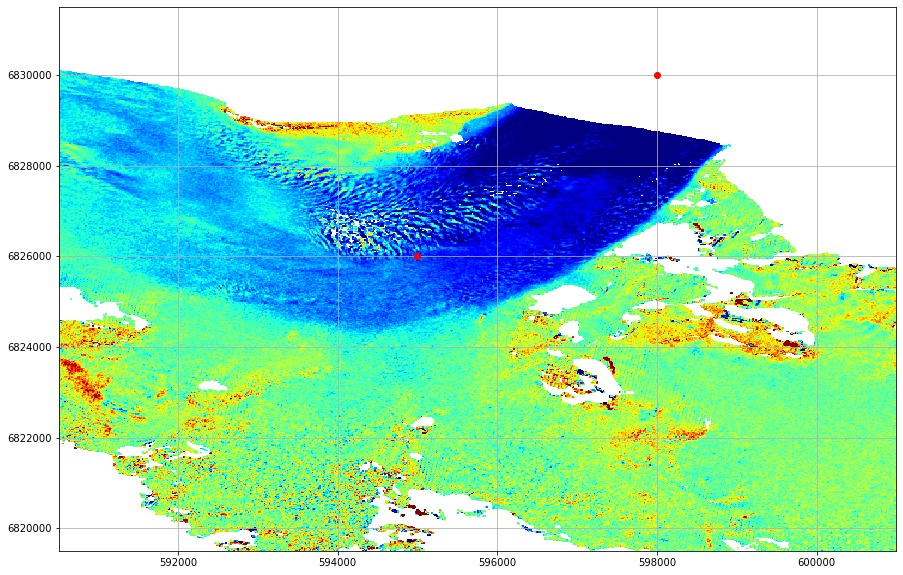

In [114]:
plt.figure(figsize=(15,10));
start_r = 1500;end_r = 2300
start_c = 1700;end_c = 2400;

x = delta_z_18_minus_17.x[start_c:end_c]
y = delta_z_18_minus_17.y[start_r:end_r]
ele = delta_z_18_minus_17.elevation[start_r:end_r, start_c:end_c]
plt.pcolormesh(x, y, ele, vmin=-10, vmax=10, cmap='jet')
#plt.plot(6830000, 596000,'ro')
plt.grid()
plt.plot(598000, 6830000,'ro')
plt.plot(595000, 6826000,'ro')

## Interpolate height fields to line, AB, from fjord up a glacier

In [168]:
## Define three points.  A in fjord, B up the glacier
A = ( 6830000, 598000)
B = ( 6826000, 595000)

dist_ab = np.sqrt( (A[0] - B[0])**2 + (A[1] - B[1])**2)
dist_ab # in meters

5000.0

In [171]:
## Create arrays of lats and lons between AB and AC
ab_y = np.linspace(A[0], B[0], 1000)
ab_x = np.linspace(A[1], B[1], 1000)
# distance along the line
d_line = np.linspace(0, dist_ab, 1000)

In [170]:
## Turn arrays into data array objects
da_ab_y = xr.DataArray(ab_y, dims='d')
da_ab_x = xr.DataArray(ab_x, dims='d')

In [173]:
## interpolate height fields to AB and AC
da_18_ab = s_002_2018.elevation.interp(x=da_ab_x, y=da_ab_y)
da_18_ab = da_18_ab.where(da_18_ab > -100, np.nan)

da_17_ab = s_002_2017.elevation.interp(x=da_ab_x, y=da_ab_y)
da_17_ab = da_17_ab.where(da_17_ab > -100, np.nan)

da_16_ab = s_002_2016.elevation.interp(x=da_ab_x, y=da_ab_y)
da_16_ab = da_16_ab.where(da_16_ab > -100, np.nan)

## Plot 2016, 2017, 2018 along AB

### AB

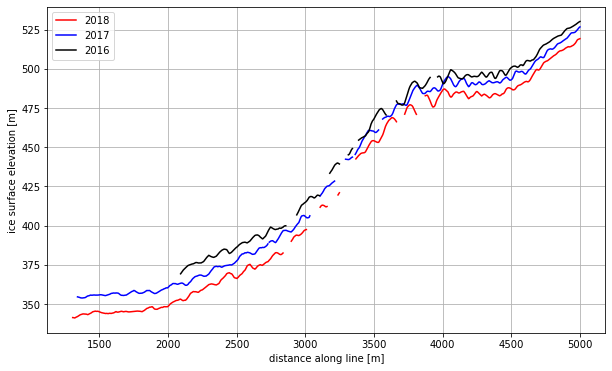

In [178]:
plt.figure(figsize=(10,6));
plt.plot(d_line, da_18_ab.values, 'r')
plt.plot(d_line, da_17_ab.values, 'b')
plt.plot(d_line, da_16_ab.values, 'k')
plt.grid()
plt.xlabel('distance along line [m]')
plt.ylabel('ice surface elevation [m]')
plt.legend(('2018','2017','2016'))

Text(0, 0.5, 'ice surface elevation difference [m]')

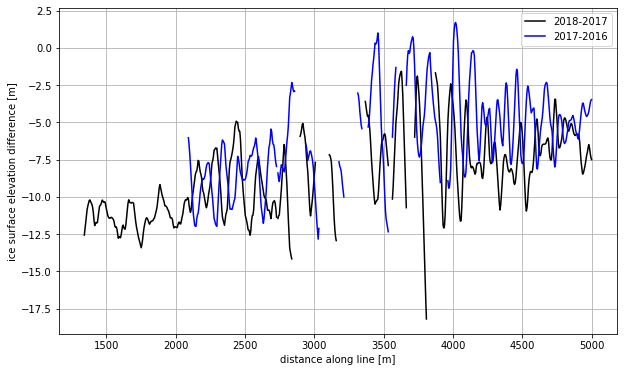

In [177]:
# plot difference 
plt.figure(figsize=(10,6));
plt.plot(d_line, da_18_ab.values-da_17_ab.values, 'k')
plt.plot(d_line, da_17_ab.values-da_16_ab.values, 'b')
plt.grid()
plt.legend(('2018-2017', '2017-2016'))
plt.xlabel('distance along line [m]')
plt.ylabel('ice surface elevation difference [m]')

### do more of these for different glaciers